In [47]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.models import resnet18

from ml_htools.torch_utils import BaseModel

In [157]:
class Model(BaseModel):
    
    def __init__(self):
        super().__init__(locals())
        self.pad = nn.ReflectionPad2d(2)
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.adapt = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.conv1(self.pad(x))
        x = F.leaky_relu(x)
        x = self.conv2(self.pad(x))
        x = F.leaky_relu(x)
        x = self.adapt(x)
        x = self.fc(x.squeeze())
        return torch.sigmoid(x)
    
    
class Model2(BaseModel):

    def __init__(self, c_in, c_outs):
        super().__init__(locals())
        dims = [c_in] + c_outs
        self.enc = nn.Sequential(*[nn.Sequential(nn.ReflectionPad2d(2),
                                   nn.Conv2d(*(c_in, c_out), kernel_size=5),
                                   nn.LeakyReLU())
                                   for c_in, c_out in zip(dims, dims[1:])])
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(c_outs[-1], 1)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.pool(x)
        print(x.shape)
        x = x.squeeze()
        print(x.shape)
        return torch.sigmoid(self.fc(x))

In [158]:
m2 = Model2(3, [8, 16, 32])
m2

Model2(
  (enc): Sequential(
    (0): Sequential(
      (0): ReflectionPad2d((2, 2, 2, 2))
      (1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): ReflectionPad2d((2, 2, 2, 2))
      (1): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): ReflectionPad2d((2, 2, 2, 2))
      (1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [134]:
m1 = Model()
m1

Model(
  (pad): ReflectionPad2d((2, 2, 2, 2))
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (adapt): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [136]:
x = torch.randint(255, (2, 3, 4, 4)).float()
x

tensor([[[[ 29., 181., 166.,  71.],
          [ 37., 122., 211.,  46.],
          [230., 110., 141., 245.],
          [197.,  27., 241., 215.]],

         [[ 47.,  59.,  76.,  34.],
          [ 65., 242., 148.,  14.],
          [ 74.,  61., 116.,  33.],
          [ 38., 222., 210.,  77.]],

         [[163., 174., 242., 221.],
          [152., 222., 174., 167.],
          [133., 110., 229.,  69.],
          [123., 236.,  22.,  87.]]],


        [[[103.,  65.,  51., 170.],
          [ 63., 203., 145.,  50.],
          [ 95., 221., 163., 128.],
          [171., 172., 160.,  75.]],

         [[ 61.,  42.,  79.,  65.],
          [ 92., 209.,  13.,  97.],
          [ 63., 237.,  28., 107.],
          [201., 151., 249., 157.]],

         [[122., 136.,  79.,  14.],
          [ 25., 110.,  18., 167.],
          [157.,  16.,  69., 144.],
          [125., 179., 164.,  45.]]]])

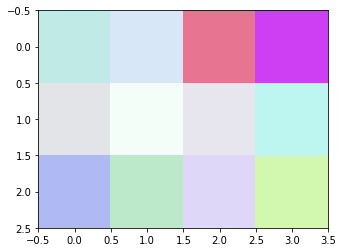

In [137]:
plt.imshow(x[0] / 255)
plt.show()

In [139]:
y = m1(x)
y.shape

torch.Size([2, 1])

In [159]:
y2 = m2(x)
y2.shape

torch.Size([2, 32, 1, 1])
torch.Size([2, 32])


torch.Size([2, 1])

In [160]:
y2

tensor([[0.5977],
        [0.7440]], grad_fn=<SigmoidBackward>)

In [109]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  